# 2022-10-10 Iterative Solvers

## Last time

* Request RC accounts
* Sparse direct solvers
  * impact of ordering on formulation
  * cost scaling
  
## Today
* Classical iterative methods
* Concept of preconditioning
* Krylov methods (focus on GMRES)
* PETSc experiments

In [3]:
using Plots
default(linewidth=3)
using LinearAlgebra
using SparseArrays

function my_spy(A)
    cmax = norm(vec(A), Inf)
    s = max(1, ceil(120 / size(A, 1)))
    spy(A, marker=(:square, s), c=:diverging_rainbow_bgymr_45_85_c67_n256, clims=(-cmax, cmax))
end

function advdiff_matrix(n; kappa=1, wind=[0, 0])
    h = 2 / (n + 1)
    rows = Vector{Int64}()
    cols = Vector{Int64}()
    vals = Vector{Float64}()
    idx((i, j),) = (i-1)*n + j
    in_domain((i, j),) = 1 <= i <= n && 1 <= j <= n
    stencil_advect = [-wind[1], -wind[2], 0, wind[1], wind[2]] / h
    stencil_diffuse = [-1, -1, 4, -1, -1] * kappa / h^2
    stencil = stencil_advect + stencil_diffuse
    for i in 1:n
        for j in 1:n
            neighbors = [(i-1, j), (i, j-1), (i, j), (i+1, j), (i, j+1)]
            mask = in_domain.(neighbors)
            append!(rows, idx.(repeat([(i,j)], 5))[mask])
            append!(cols, idx.(neighbors)[mask])
            append!(vals, stencil[mask])
        end
    end
    sparse(rows, cols, vals)
end

advdiff_matrix (generic function with 1 method)

# Request an RC account

## https://www.colorado.edu/rc
* This gives `ssh` login access. We'll use [Alpine](https://curc.readthedocs.io/en/latest/clusters/alpine/index.html), which is a modern CPU and GPU cluster.
* This will be good for benchmarking and larger runs. We'll also use GPUs later in class.

## PETSc
* We'll start using [PETSc](https://petsc.org) this week.
* You can build PETSc on your laptop. You'll need C development tools.
  * Linux: use package manager (`apt install`, `dnf install`, ...)
  * OSX: install xcode, many people like [homebrew](https://brew.sh/) as a package manager
  * Windows: WSL then follow Linux instructions (or MSYS2 or Cygwin)
  * Any: install Docker, then use our image
  
## Zulip
* [Join for discussions](https://cu-numpde.zulipchat.com/join/aovsprei6v6nrx7atvwqq7vv/)

# How expensive how fast?

Suppose we have a second order accurate method in 3D.

In [4]:
n = 2. .^ (2:13)
N = n.^3
error = (50 ./ n) .^ 2
seconds = 1e-10 * N.^2
hours = seconds / 3600
cloud_dollars = 3 * hours
kW_hours = 0.2 * hours
barrel_of_oil = kW_hours / 1700
kg_CO2 = kW_hours * 0.709
;

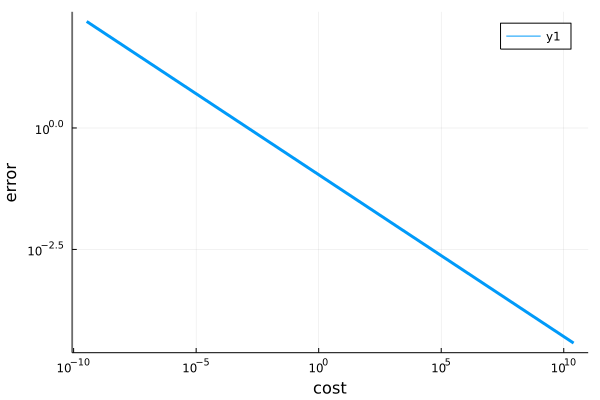

In [6]:
cost = cloud_dollars
plot(cost, error, xlabel="cost", ylabel="error", xscale=:log10, yscale=:log10)

* [Barrel of oil equivalent](https://en.wikipedia.org/wiki/Barrel_of_oil_equivalent)
* [Electricity emission factor](https://www.epa.gov/energy/greenhouse-gases-equivalencies-calculator-calculations-and-references)

# Outlook on sparse direct solvers

* Sparse direct works well for 2D and almost-2D problems to medium large sizes
  * High order FD methods make sparse direct cry
  * High order finite element are okay, but [not high-continuity splines](https://doi.org/10.1016/j.cma.2011.11.002)
  * Almost-2D includes a lot of industrial solid mechanics applications
    * The body of a car, the frame of an airplane
* Sparse direct is rarely usable in "fully 3D" problems
  * "thick" structures
    * soil mechanics, hydrology, building foundations, bones, tires
  * fluid mechanics
    * aerodynamics, heating/cooling systems, atmosphere/ocean
* Setup cost (factorization) is much more expensive than solve
  * Amortize cost in time-dependent problems
    * Rosenbrock methods: factorization reused across stages
    * "lag" Jacobian in Newton (results in "modified Newton")
    * "lag" preconditioner with matrix-free iterative methods (Sundials, PETSc)
  * Factorization pays off if you have many right hand sides

# Why iterative solvers over direct solvers?

* Less reliable, more leaky abstraction
* More sensitive to problem formulation
* Slower for small problems
* Several different strategies, each with tuning knobs
* Accuracy tolerances needed

## $O(N)$ solvers available for many important problems
* High-order discretization *can* be okay

# Gradient descent

Suppose $A$ is a symmetric positive definite matrix and consider the scalar functional

$$f(u) = \frac 1 2 u^T A u - b^T u . $$

Then the gradient is

$$\nabla_u f = A u - b .$$

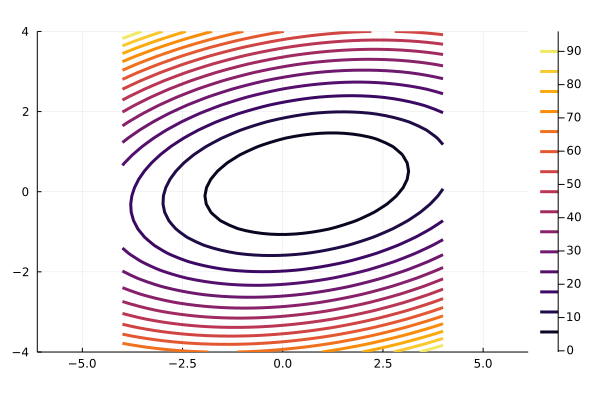

In [11]:
x = LinRange(-4, 4, 40)
A = [2 -1; -1 8]
b = [1, 1] 
f(u) = .5 * u' * A * u - b' * u
contour(x, x, (u1, u2) -> f([u1, u2]), aspect_ratio=:equal)

# Aside: Derivative of a dot product

Let $f(\boldsymbol x) = \boldsymbol y^T \boldsymbol x = \sum_i y_i x_i$ and compute the derivative

$$ \frac{\partial f}{\partial \boldsymbol x} = \begin{bmatrix} y_0 & y_1 & \dotsb \end{bmatrix} = \boldsymbol y^T . $$

Note that $\boldsymbol y^T \boldsymbol x = \boldsymbol x^T \boldsymbol y$ and we have the product rule,

$$ \frac{\partial \lVert \boldsymbol x \rVert^2}{\partial \boldsymbol x} = \frac{\partial \boldsymbol x^T \boldsymbol x}{\partial \boldsymbol x} = 2 \boldsymbol x^T . $$

Also,
$$ \frac{\partial \lVert \boldsymbol x - \boldsymbol y \rVert^2}{\partial \boldsymbol x} = \frac{\partial (\boldsymbol x - \boldsymbol y)^T (\boldsymbol x - \boldsymbol y)}{\partial \boldsymbol x} = 2 (\boldsymbol x - \boldsymbol y)^T .$$

# Aside: Variational notation

It's convenient to express derivatives in terms of how they act on an infinitessimal perturbation. So we might write

$$ \delta f = \frac{\partial f}{\partial x} \delta x .$$

(It's common to use $\delta x$ or $dx$ for these infinitesimals.) This makes inner products look like a normal product rule

$$ \delta(\mathbf x^T \mathbf y) = (\delta \mathbf x)^T \mathbf y + \mathbf x^T (\delta \mathbf y). $$

A powerful example of variational notation is differentiating a matrix inverse

$$ 0 = \delta I = \delta(A^{-1} A) = (\delta A^{-1}) A + A^{-1} (\delta A) $$
and thus
$$ \delta A^{-1} = - A^{-1} (\delta A) A^{-1} $$

# Try gradient descent

$$ u_{k+1} = u_k - \omega \nabla_u f $$

In [12]:
function grad_descent(loss, grad, u0; omega=1e-3, tol=1e-5)
    """Minimize loss(c) via gradient descent with initial guess u0
    using learning rate gamma.  Declares convergence when gradient
    is less than tol or after 500 steps.
    """
    u = copy(u0)
    uhist = [copy(u)]
    lhist = [loss(u)]
    for it in 1:500
        g = grad(u)
        u -= omega * g
        push!(uhist, copy(u))
        push!(lhist, loss(u))
        if norm(g) < tol
            break
        end
    end
    (u, hcat(uhist...), lhist)
end

grad_descent (generic function with 1 method)

# Visualize gradient descent

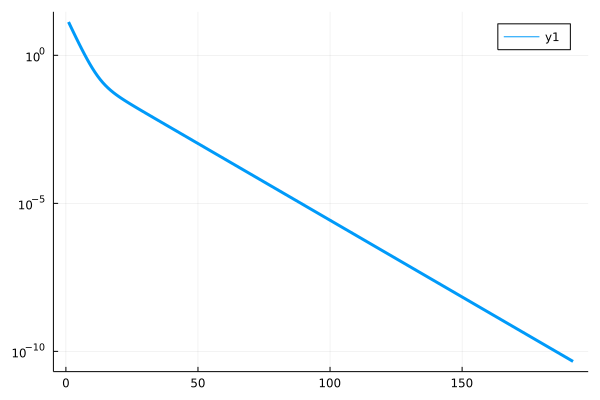

In [60]:
A = [1 1; 1 30]
loss(u) = .5 * u' * A * u
grad(u) = A * u
u, uhist, lhist = grad_descent(loss, grad, [.9, .9],
    omega=.06)
plot(lhist, yscale=:log10)

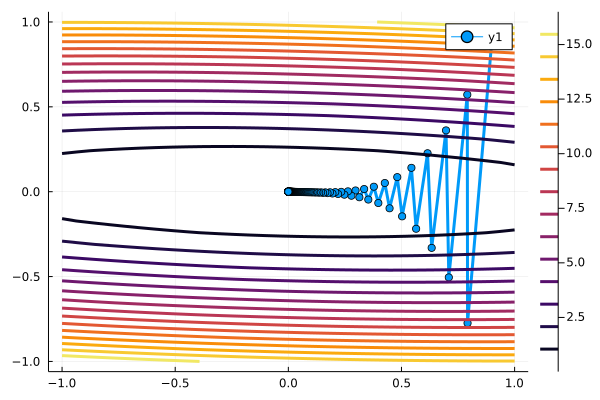

In [61]:
plot(uhist[1, :], uhist[2, :], marker=:circle)
x = LinRange(-1, 1, 30)
contour!(x, x, (x,y) -> loss([x, y]))

# Richardson iteration

The simplest iterative method is [Richardson's method](https://en.wikipedia.org/wiki/Modified_Richardson_iteration), which solves $A u = b$ by the iteration
$$ u_{k+1} = u_k + \omega (b - A u_k) $$
where $\omega > 0$ is a damping parameter and $u_0$ is an initial guess (possibly the zero vector).

* Algebraically equivalent to gradient descent when $A$ is SPD
* Non-symmetric matrices are harder to visualize

# Richardson convergence

$$ u_{k+1} = u_k + \omega (b - A u_k) $$

If $b = A u_*$, this iteration is equivalent to
\begin{align}
u_{k+1} - u_* &= (u_k - u_*) - \omega A (u_k - u_*) \\
&= (I - \omega A) (u_k - u_*) .
\end{align}
It is convenient for convergence analysis to identify the "error" $e_k = u_k - u_*$, in which this becomes
$$ e_{k+1} = (I - \omega A) e_k $$
or
$$ e_k = (I - \omega A)^k e_0 $$
in terms of the initial error.  Evidently powers of the *iteration matrix* $I - \omega A$ tell the whole story.

Suppose that the eigendecomposition
$$ X \Lambda X^{-1} = I - \omega A $$
exists.  Then
$$ (I - \omega A)^k = (X \Lambda X^{-1})^k = X \Lambda^k X^{-1} $$
and the convergence (or divergence) rate depends only on the largest magnitude eigenvalue.
This analysis isn't great for two reasons:

1. Not all matrices are diagonalizable.
2. The matrix $X$ may be very ill-conditioned.

# Aside: Schur decomposition

We can repair these weaknesses by using the [Schur decomposition](https://en.wikipedia.org/wiki/Schur_decomposition)
$$ Q R Q^h = I - \omega A $$
where $R$ is right-triangular and $Q$ is unitary (i.e., orthogonal if real-valued; $Q^h$ is the Hermitian conjugate of $Q$).
The Schur decomposition always exists and $Q$ has a condition number of 1.

* Where are the eigenvalues in $R$?

Evidently we must find $\omega$ to minimize the maximum eigenvalue of $I - \omega A$.  We can do this if $A$ is well conditioned, but not in general.

# Ill-conditioning

## Question: What is the condition number of the Laplacian on 100 evenly spaced points?

* How does it scale under grid refinement?

In [74]:
A = advdiff_matrix(20)
cond(Matrix(A))

178.06427461085963

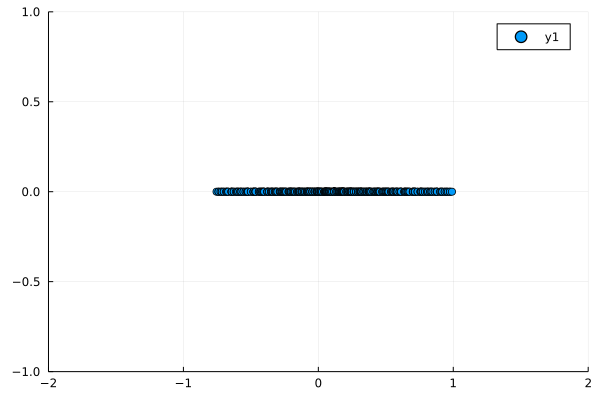

In [76]:
omega = .002
ev = eigvals(Matrix(I - omega * A))
scatter(real.(ev), imag.(ev), xlim=(-2, 2), ylim=(-1, 1))

# Monic polynomials small on the spectrum

Equivalently to finding $\omega$ such that $\lVert I - \omega A \rVert$ is minimized, we may seek a monic polynomial $p(z) = 1 - \omega z$ that minimizes

$$ \max_{\lambda \in \sigma(A)} \lvert p(\lambda) \rvert . $$

This concept can be extended to higher degree polynomials, which is essentially what Krylov methods do (discovering the polynomial adaptively, weighted by the right hand side).

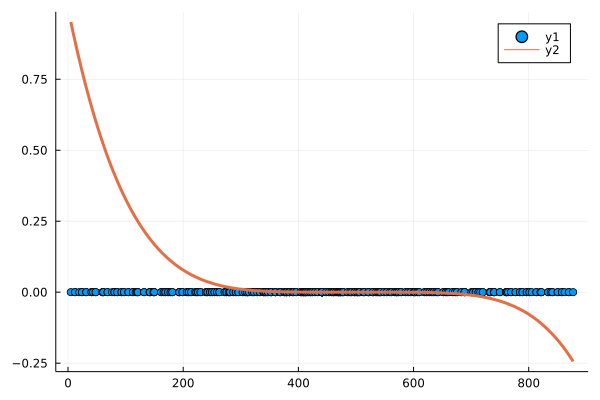

In [79]:
ev = eigvals(Matrix(A))
scatter(real.(ev), zero.(ev))
plot!(x -> (1 - omega * x)^5)

# Preconditioning

Preconditioning is the act of creating an "affordable" operation "$P^{-1}$" such that $P^{-1} A$ (or $A P^{-1}$) is is well-conditoned or otherwise has a "nice" spectrum.  We then solve the system

$$ P^{-1} A x = P^{-1} b \quad \text{or}\quad A P^{-1} \underbrace{(P x)}_y = b $$

in which case the convergence rate depends on the spectrum of the iteration matrix
$$ I - \omega P^{-1} A . $$

* The preconditioner must be applied on each iteration.
* It is *not* merely about finding a good initial guess.

There are two complementary techniques necessary for efficient iterative methods:

* "accelerators" or Krylov methods, which use orthogonality to adaptively converge faster than Richardson
* preconditioners that improve the spectrum of the preconditioned operator

Although there is ongoing research in Krylov methods and they are immensely useful, I would say preconditioning is 90% of the game for practical applications, particularly as a research area.

# Krylov subspaces

All matrix iterations work with approximations in a *Krylov subspace*, which has the form

$$ K_n = \big[ b \big| Ab \big| A^2 b \big| \dotsm \big| A^{n-1} b \big] . $$

This matrix is horribly ill-conditioned and cannot stably be computed as written.  Instead, we seek an orthogonal basis $Q_n$ that spans the same space as $K_n$.  We could write this as a factorization

$$ K_n = Q_n R_n $$

where the first column $q_0 = b / \lVert b \rVert$.  The $R_n$ is unnecessary and hopelessly ill-conditioned, so a slightly different procedure is used.

# Arnoldi iteration

The Arnoldi iteration applies orthogonal similarity transformations to reduce $A$ to [Hessenberg form](https://en.wikipedia.org/wiki/Hessenberg_matrix), starting from a vector $q_0 = b$,

$$ A = Q H Q^* . $$

Let's multiply on the right by $Q$ and examine the first $n$ columns,

$$ A Q_n = Q_{n+1} H_n $$
where $H_n$ is an $(n+1) \times n$ Hessenberg matrix.

# Aside: Conditioning of Arnoldi process
The Arnoldi process is well-conditioned because $Q$ is orthogonal and

$$ \lVert H_n \rVert \le \lVert Q_{n+1}^* \rVert \lVert A \rVert \lVert Q_n \rVert \le \lVert A \rVert $$.

For a lower bound, we have

$$ \sigma_{\min}(A)^2 \le x^* A^* A x $$

for all $x$ of norm 1.  It must also be true for any $x = Q_n y$ where $\lVert y\rVert = 1$, thus

$$ \sigma_{\min}(A)^2 \le y^* Q_n^* A^* A Q_n y = y^* H_n^* Q_{n+1}^* Q_{n+1} H_n y = y^* H_n^* H_n y . $$

# GMRES
$$ A Q_n = Q_{n+1} H_n $$

GMRES (Generalized Minimum Residual) minimizes
$$ \lVert A x - b \rVert $$
over the subspace $Q_n$.  I.e., $x = Q_n y$ for some $y$.  By the Arnoldi recurrence, this is equivalent to
$$ \lVert Q_{n+1} H_n y - b \lVert $$
which can be solved by minimizing
$$ \lVert H_n y - Q_{n+1}^* b \rVert . $$
Since $q_0 = b/\lVert b \lVert$, the least squares problem is to minimize
$$ \Big\lVert H_n y - \lVert b \rVert e_0 \Big\rVert . $$
The solution of this least squares problem is achieved by incrementally updating a $QR$ factorization of $H_n$.

## Notes
* The solution $x_n$ constructed by GMRES at iteration $n$ is not explicitly available.  If a solution is needed, it must be constructed by solving the $(n+1)\times n$ least squares problem and forming the solution as a linear combination of the $n$ vectors $Q_n$.  The leading cost is $2mn$ where $m \gg n$.
* The residual vector $r_n = A x_n - b$ is not explicitly available in GMRES.  To compute it, first build the solution $x_n$ as above.
* GMRES minimizes the 2-norm of the residual $\lVert r_n \rVert$ which is equivalent to the $A^* A$ norm of the error $\lVert x_n - x_* \rVert_{A^* A}$.

# More notes on GMRES

* GMRES needs to store the full $Q_n$, which is unaffordable for large $n$ (many iterations).  The standard solution is to choose a "restart" $k$ and to discard $Q_n$ and start over with an initial guess $x_k$ after each $k$ iterations.  This algorithm is called GMRES(k).  PETSc's default solver is GMRES(30) and the restart can be controlled using the run-time option `-ksp_gmres_restart`.
* Most implementations of GMRES use classical Gram-Schmidt because it is much faster in parallel (one reduction per iteration instead of $n$ reductions per iteration).  The PETSc option `-ksp_gmres_modifiedgramschmidt` can be used when you suspect that classical Gram-Schmidt may be causing instability.
* There is a very similar (and older) algorithm called GCR that maintains $x_n$ and $r_n$.  This is useful, for example, if a convergence tolerance needs to inspect individual entries.  GCR requires $2n$ vectors instead of $n$ vectors, and can tolerate a nonlinear preconditioner.  FGMRES is a newer algorithm with similar properties to GCR.

# Experiments in [PETSc](https://petsc.org)

* PETSc = Portable Extensible Toolkit for Scientific computing
* `./configure`, `make`
  * Depends on BLAS and LAPACK (default system or package manager)
    * or `./configure --download-f2cblaslapack --download-blis`
  * Depends on MPI for parallelism (package manager)
    * or `./configure --download-mpich` (or `--download-openmpi`)
* `docker run -it --rm jedbrown/petsc`
* Lots of examples (mostly C and Fortran, some Python)
* Experimental bindings in Rust, Julia
* We'll use `src/snes/tutorials/ex15.c`
  * "p-Bratu": combines p-Laplacian with Bratu nonlinearity
  $$ -\nabla\cdot\big(\kappa(\nabla u) \nabla u\big) - \lambda e^u = f $$
  * Newton solver with Krylov on each iteration

# Simple preconditioners

## Jacobi `-pc_type jacobi`

$$ P_{\text{Jacobi}}^{-1} = D^{-1} $$
where $D$ is the diagonal of $A$.

## Gauss-Seidel `-pc_type sor`

$$ P_{GS}^{-1} = (L+D)^{-1} $$
where $L$ is the (strictly) lower triangular part of $A$.  The upper triangular part may be used instead, or a symmetric form
$$ P_{SGS}^{-1} = (L+U)^{-1} A \Big( I - (L+D)^{-1} \Big) . $$

### Over-relaxation

`-pc_sor_omega 1.` is default (Gauss-Seidel)

## Run p-Laplacian example
```console
$ cd src/snes/tutorials
$ make ex15
$ ./ex15 -da_refine 2 -dm_view
$ ./ex15 -ksp_monitor -pc_type jacobi
$ ./ex15 -snes_view
```

## Experiments

* How does iteration count vary under grid refinement?
* How sensitive is it to parameters
  * p-Laplacian `-p` $> 1$ and `-epsilon` $> 0$
  * Bratu `-lambda` $< 6.8$
* How sensitive to `-ksp_gmres_restart`?
* `-ksp_monitor_true_residual`
* `-ksp_view_eigenvalues`

# Symmetric problems

## Lanczos iteration: like GMRES for symmetric problems

If $A$ is symmetric, then $H = Q^T A Q$ is also symmetric.  Since $H$ is Hessenberg, this means $H$ is tridiagonal.  Instead of storing $Q_n$, it is sufficient to store only the last two columns since the iteration satisfies a 3-term recurrence.  The analog of GMRES for the symmetric case is called MINRES and is also useful for solving symmetric indefinite problems.

## Conjugate Gradients: changing the norm

Instead of minimizing the $A^T A$ norm of the error, the Conjugate Gradient method minimizes the $A$ norm of the error.  For $A$ to induce a norm, it must be symmetric positive definite.  [Jeremy Shewchuck's guide to CG](http://www.cs.cmu.edu/%7Equake-papers/painless-conjugate-gradient.pdf) is an excellent resource.